# Natural Language Processing 2024 – Ex. 2

**Add the names and ID of the submitting students here:**

1. Yaniv Gabay - 205745615 - yanivga@edu.hac.ac.il


2. Shahar Asher - 209305408 - shaharas@edu.hac.ac.il


3. Hadar Liel Harush - 211721568 - hadarhar@edu.hac.ac.il


In this exercise we will perform the task of Sentiment analysis over the IMDB movie review dataset.

The dataset has around 50K movie reviews with each review labeled as "positive" or "negative".

Our goal is given the review we want to classifiy it as positive or negative, this task is also called "Sentiment Analysis"

Below you can find a suggestion of the order things should be implemented, you can follow this or do it your own way.

The exercise has several stages:

1. Downloading and cleaning the data
2. Running some basic analysis
3. Training a Feed Forward network to perform the task using classification
4. Training a Bi-Dir LSTM to perform the task
5. Playing with paramters to see if we get better results

Please sumbit the notebook after it's running stage. Grade will be given for clean code, with comments and explanations

In [37]:
import nltk
import pandas as pd
from IPython.display import display
import re
!pip install contractions
!pip install afinn
import contractions
from afinn import Afinn

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())
nltk.download('stopwords')

#from google.colab import files
#import io

cuda
True


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# Dictionary to store uploaded files
# uploaded_file = files.upload()

# Data download and cleaning

1. Download the IMDB dataset.

2. Clean the data:
* Remove URLs, HTML tags and non-alphanumeric characters
* Remove stop-words (use NLTK)
* Lowercase the dataset
* (Optional) Anything else you think can help...

Show one example of a review before and after this cleaning (find a review which has at least one URL/HTML tag/Non-aplhanumeric characters)



In [39]:
# we tried to spell correct the data but the results very not good
# so we decided to not use it example "muslims" into "musea"

#another decision,is when removing stopword, to exlude all sentiment related words.
#after searching for a reasonable solution, we found AFINN sentiment analysis

#afinn object
afinn = Afinn()

digitplaceholder = 'DIGPLACHOLD' # <DIGIT>



#created a function to export the data
#so we can eaisly observe the data manually.
#sometimes, best to observe the data manually.
def export_curr_data_to_csv(num_of_question,df):
    try:
         output_file = "curr_data"+num_of_question+".csv"
         df.to_csv(output_file, index=False)
         return
    except Exception as e:
          print("Error loading data: {}".format(e))
          exit(1)

#basic cleaning function
# need to drop the html tags, urls, non-alphanumeric characters, convert to lowercase, remove stopwords, turn digits into token
          # TO ADD: sentiment related stopwords, like not , should be kept.
def clean_text(text):
    #1 Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #2 Remove URLs
    text = re.sub(r'http\S+', '', text)
    #3 Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)


    #4 Convert to lowercase
    text = text.lower()



    # Replace non-ASCII characters
    #after finding out there were several non-ascii chars
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    words = text.split()

    #5 Remove stopwords
    #set of stop words
    stop_words = set(stopwords.words('english'))

    #every stop word, which has sentiment of 0, will be removed
    #we can even try to remove -1 and +1 cause of weak sentiment
    #check those print statments to see how it works:
    #print("not value:"+str(afinn.score('not')))
    #print("bad value:"+str(afinn.score('bad')))
    #print("horrible value:"+str(afinn.score('horrible')))
    #print("lion value:"+str(afinn.score('lion')))
    sentiment_stop_words = {word for word in stop_words if afinn.score(word) != 0}

    #STILL WORDS like NOT which affect sentiment
    # are removed, we can try to keep them, using a list of commong sentiment words
    #and removing that from stopwords
    stop_words = stop_words - sentiment_stop_words - {'not','no','nor','neither','never','none','nobody','nothing','nowhere'}
    text = ' '.join([word for word in words if word not in stop_words])
    #6 turn Digits into Token

    #3rd,8th etc. will be replaced with ALPHANUM
    pattern = r'\b(?:\d+[a-zA-Z]|[a-zA-Z]+\d)[a-zA-Z\d]*\b'
    placeholder = 'ALPHANUM'
    text = re.sub(pattern, placeholder, text)
    text = re.sub(r'\d+', digitplaceholder, text)
    #need to decide what to do with 3rd, 4th  etc.
    # as this moment 3rd will turn into DIGPLACHOLDrd, which is not good.
    #7 additional steps if needed

    return text
def load_text(filename):
   file_path = filename
   #IMDB data set has header at 0 row
   data = pd.read_csv(file_path, header=0, names=['review', 'sentiment'])
   display(data.head())


    # Apply the cleaning function to the review column
   data['review'] = data['review'].apply(clean_text)
   return data

# Example usage
example_review = "This is an example review with HTML <b>bold</b> tags and a URL: https://example.com"
cleaned_review = clean_text(example_review)
print("Original:", example_review)
print("Cleaned:", cleaned_review)
try:
# Load the data

    file_path = './IMDB Dataset.csv'
    data = pd.read_csv(file_path, header=0,
                       names=['review', 'sentiment'],
                       encoding='utf-8', on_bad_lines='warn',
                       engine = 'python')

    print(data.shape[0])
    data_orig_copy = data.copy()
    print("cleaned text printing:\n")
    display(data.head())
    print(data.sample(10)['review'])
    #export_curr_data_to_csv("1",data)
   # describe = data.describe()
   # print(describe)


except Exception as e:
    print("Error loading data: {}".format(e))
    exit(1)


Original: This is an example review with HTML <b>bold</b> tags and a URL: https://example.com
Cleaned: example review html bold tags url
50000
cleaned text printing:



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


3278     While the original titillates the intellect, t...
7178     the reason why i gave this movie a 4 was for a...
5663     While there is a lot to recommend about Maetel...
38438    I have, "Things to Come," on D.V.D. and it's v...
36442    Daniel Day-Lewis is Christy Brown, a victim of...
49699    A country-boy Aussie-Rules player (Mat) goes t...
22835    One: your screen will be filled with beautiful...
29660    One of the best documentaries released in rece...
44550    This film has an interesting plot, but the act...
20614    I made sure to see this film because it is a 1...
Name: review, dtype: object


# Tokenization

1. Tokenize the dataset (you can tokenize using spaces or use more robust methods from NLTK)
2. (Optional) Lemmatize the text (you can use NLTK) this can improve results
3. Lemmatize should be carfully be done, so we wont lose too much.
4. Show an example of 3 sentences before and after this process

In [40]:
from nltk.corpus import wordnet
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

#we decided to use POS tagging



# contractions do:
#will make she's into she is
def expand_text_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text




# this prevent the lemmatize process from taking
# words like was and convert them into "wa"
auxiliary_verbs = {"am", "is", "are", "was", "were", "be", "being", "been", "will", "shall", "would", "should", "can", "could", "may", "might", "must", "do", "does", "did", "have", "has", "had"}

def get_wordnet_pos(treebank_tag):
    """Map POS tag to the format accepted by WordNetLemmatizer."""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0].upper(), wordnet.NOUN)
def tokenize_and_lemmatize(text):

    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    #print("POS Tags:", pos_tags)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token, pos in pos_tags:
        # Skip lemmatization for auxiliary verbs
        #from our expereince we saw that the lemmatize function
        #converts words like was into wa
        #and in general didnt handle aux verbs well
        if token in auxiliary_verbs:

            lemmatized_tokens.append(token)
        else:

            lemma = lemmatizer.lemmatize(token, get_wordnet_pos(pos))
            lemmatized_tokens.append(lemma)

    return ' '.join(lemmatized_tokens)



# Example sentences
example_sentences = [
    "The cats are chasing the mice.",
    "He was running late for the meeting.",
    "She's not enjoying the sunny weather.",
    "I didnt like that movie at all, very bad",
    "despite the fact that the movie was bad, i still enjoyed it"
]


# Process and display the examples
for sentence in example_sentences:
    cleaned_text = clean_text(sentence)
    expanded_sentence = expand_text_contractions(cleaned_text)

    processed = tokenize_and_lemmatize(expanded_sentence)
    print("0.Original:", sentence)
    print("1.Cleaned:", cleaned_text)
    print("2.Expanded:", expanded_sentence)
    print("3.Processed:", processed, "\n")

0.Original: The cats are chasing the mice.
1.Cleaned: cats chasing mice
2.Expanded: cats chasing mice
3.Processed: cat chase mouse 

0.Original: He was running late for the meeting.
1.Cleaned: running late meeting
2.Expanded: running late meeting
3.Processed: run late meeting 

0.Original: She's not enjoying the sunny weather.
1.Cleaned: not enjoying sunny weather
2.Expanded: not enjoying sunny weather
3.Processed: not enjoy sunny weather 

0.Original: I didnt like that movie at all, very bad
1.Cleaned: didnt like movie bad
2.Expanded: did not like movie bad
3.Processed: did not like movie bad 

0.Original: despite the fact that the movie was bad, i still enjoyed it
1.Cleaned: despite fact movie bad still enjoyed
2.Expanded: despite fact movie bad still enjoyed
3.Processed: despite fact movie bad still enjoy 



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Basic analysis

Perfrom some analysis on the data
1. Show the number percentage of negative/positive review (label balancing)
2. Plot some statistics on the length of review (after our cleaning process)
3. (Optional) show anything else you think is important

In [41]:
#beware long run time
# 6-7 min run time (POS tagging takes time)
def final_preprocess(review):
    # First, expand contractions
    after_contractions = expand_text_contractions(review)
    # Then, tokenize and lemmatize the expanded review
    processed_review = tokenize_and_lemmatize(after_contractions)
    return processed_review

# Apply the preprocess_review function to each review in the DataFrame
#we created another col here, instead of rewriting the data.
#we wanted to maybe play with both results, and see how good
#tokenize_and_lemmatize and expand_text_contractions are.
data['processed_review'] = data['review'].apply(final_preprocess)

#data right now is :
#1.review |2. sentiment |3. processed_review
#:
#1.review - is after preprocessing
#2.sentiment - is the original data (havent changed)
#3.processed_review - is after clean and final preprocess so proccesed.

# Display the first few rows to verify the changes
print(data[['review', 'processed_review']].head())
#export_curr_data_to_csv("3",data)



                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                    processed_review  
0  One of the other reviewer has mention that aft...  
1  A wonderful little production . < br / > < br ...  
2  I think this was a wonderful way to spend time...  
3  Basically there is a family where a little boy...  
4  Petter Mattei 's `` Love in the Time of Money ...  


In [42]:
##### label balancing
label_counts = data_orig_copy['sentiment'].value_counts(normalize=True) * 100
print(label_counts)



positive    50.0
negative    50.0
Name: sentiment, dtype: float64


Statistics on the length of cleaned reviews:
count    50000.000000
mean      1325.447440
std       1000.744983
min         34.000000
25%        705.000000
50%        983.000000
75%       1611.000000
max      13553.000000
Name: review_length, dtype: float64
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


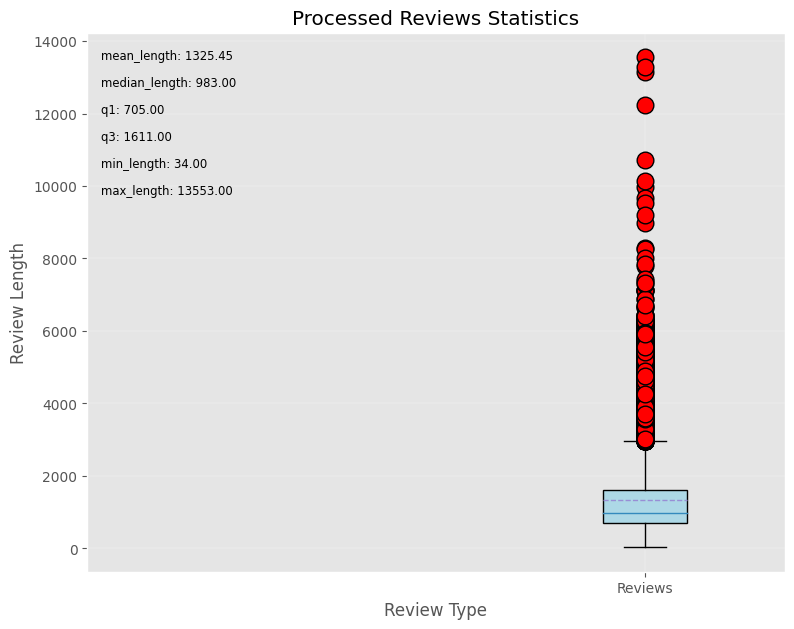

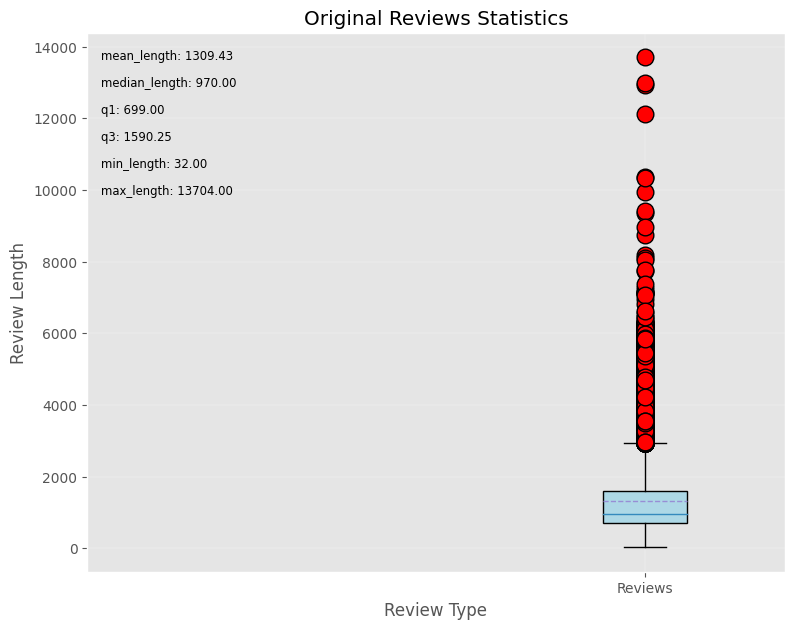

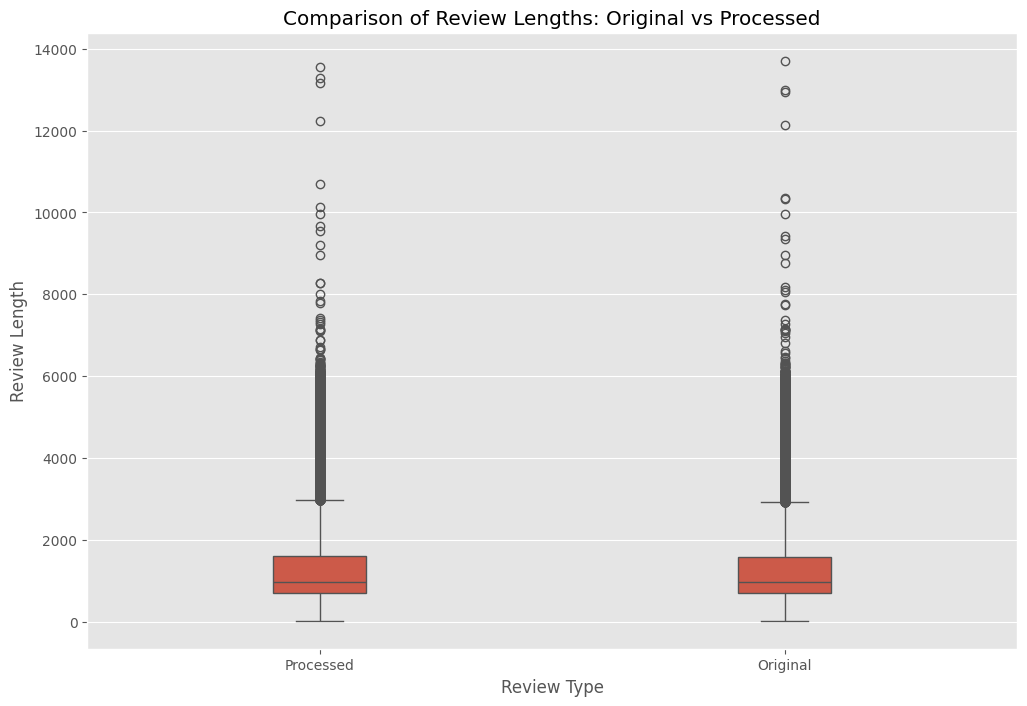

In [43]:
# Calculating the length of each cleaned review
data['review_length'] = data['processed_review'].apply(len)
export_curr_data_to_csv("4",data)
data_orig_copy['review_length'] = data_orig_copy['review'].apply(len)
# Displaying basic statistics
print("Statistics on the length of cleaned reviews:")
print(data['review_length'].describe())
print(data_orig_copy['review_length'].describe())


def calculate_review_statistics(review_lengths):
    """
    Calculate and return a dictionary of statistics for a given Series of review lengths.
    """
    return {
        'mean_length': review_lengths.mean(),
        'median_length': review_lengths.median(),
        'q1': review_lengths.quantile(0.25),
        'q3': review_lengths.quantile(0.75),
        'min_length': review_lengths.min(),
        'max_length': review_lengths.max(),
    }


import matplotlib.pyplot as plt


processed_review_stats = calculate_review_statistics(data['review_length'])

original_review_stats = calculate_review_statistics(data_orig_copy['review_length'])



def plot_review_statistics(review_lengths, stats, title):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(9, 7))
    bp = ax.boxplot(review_lengths, vert=True, patch_artist=True, showmeans=True, meanline=True, showfliers=True, showcaps=True,flierprops=dict(marker='o', markerfacecolor='red',markeredgecolor='black', markersize=12, linestyle='none'))

    # Customizing the boxplot appearance
    bp['boxes'][0].set_facecolor('lightblue')

    ax.grid(True, which='both', linestyle='-', linewidth=0.2)

    # Setting the x-axis limit to make room for annotations
    ax.set_xlim(0, 1.25)

    # Annotating statistics
    stat_y_base = max(review_lengths)  # Start annotations at the top
    y_offset = (max(review_lengths) - min(review_lengths)) * 0.03  # Space between annotations

    legend_labels = []
    for i, (stat_name, stat_value) in enumerate(stats.items()):
        legend_labels.append(f'{stat_name}: {stat_value:.2f}')

    # Finalizing the plot
    ax.set_title(title)
    ax.set_ylabel('Review Length')
    ax.set_xticklabels(['Reviews'])  # Adjust tick label as needed
    ax.set_xlabel('Review Type')
    #ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #ax.legend(legend_labels, loc='upper left', fontsize='small', shadow=True, fancybox=True, title='Statistics')
    for i, label in enumerate(legend_labels):
        ax.text(0.02, 0.95 - i * 0.05, label, transform=plt.gca().transAxes, fontsize='small')

    plt.show()
    return fig, ax

# Plot them separately
plot_review_statistics(data['review_length'], processed_review_stats, 'Processed Reviews Statistics')
plot_review_statistics(data_orig_copy['review_length'], original_review_stats, 'Original Reviews Statistics')


#graph to show both of them using seaborn
# Create a new DataFrame for plotting
!pip install seaborn
import seaborn as sns
length_comparison = pd.DataFrame({
    "Length": pd.concat([data['review_length'], data_orig_copy['review_length']]),
    "Type": ["Processed"] * len(data) + ["Original"] * len(data_orig_copy)
})




plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Length', data=length_comparison, whis=1.5, width=0.2)
plt.title('Comparison of Review Lengths: Original vs Processed')
plt.ylabel('Review Length')
plt.xlabel('Review Type')
plt.show()

##### we can show the pos tags of the words in a graph or as stats
##### as a cake!

# Preparing the dataset for training
we can also use glove or previously used models as the first layer
1. Choose your vocabulary size K (should be between 1000 and 3000)
2. Find the top K frequent words in your database
3. Create word indexes like we did in class, for any word not in your top K  words replace with \<UNK\>. Remember to add an index for the \<PAD\> token.
4. Create a new dataset with indexes instead of words later to be used for training
5. Convert your labels to numeric representation (that your network can deal with).

Split the dataset to 80% traind and 20% test, remember to keep the balance between labels!
we need to make sure, we still have enough labels on both sides



In [44]:
from sklearn.model_selection import train_test_split


# Make sure, the preprocessed data is data['processed_review']
from collections import Counter

#vocabulary side
K = 3000

all_tokens = [token for sublist in data['processed_review'].str.split().tolist() for token in sublist]

token_counts = Counter(all_tokens)

vocab = {word for word, count in token_counts.most_common(K)}
print(vocab)
#if digitplaceholder in vocab:
   # print("Digit placeholder found in vocabulary!")

word_to_index = {word: idx + 3 for idx, word in enumerate(vocab)}
word_to_index[digitplaceholder] = 2 # Start from 2 to reserve indices for special tokens
word_to_index['<UNK>'] = 1  # Unknown words
word_to_index['<PAD>'] = 0  # Padding

def text_to_sequence(text):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in text.split()]

data['indexed_text'] = data['processed_review'].apply(text_to_sequence)
print(data['indexed_text'].head())

#hello world <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>.... 500

def pad_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            seq += [word_to_index['<PAD>']] * (maxlen - len(seq))
        else:
            seq = seq[:maxlen]
        padded_sequences.append(seq)
    return padded_sequences

maxlen = 500  # Choose a suitable maximum sequence length
data['padded_sequences'] = pad_sequences(data['indexed_text'].tolist(), maxlen)
print(data['padded_sequences'].head())
#export_curr_data_to_csv("5",data)
for i, seq in enumerate(data['padded_sequences'].head()):
    print(f"Sequence {i+1}: Length = {len(seq)}")
    #print(seq)
    print("\n")
#splitting test and train
#using sklearn model selection, we can split the data into test and train
#and give a paramater to maintain the same distribution of labels

#first numerate the sentiment col
# Convert sentiment labels from 'positive'/'negative' to 1/0
data['numeric_sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

features = data['padded_sequences'].tolist()
labels = data['numeric_sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)



{'favor', 'OK', 'college', 'already', 'whatever', 'does', 'prefer', 'rich', 'Okay', 'content', 'gore', 'Highly', 'could', 'frame', 'pure', "'The", 'magnificent', 'violent', 'Apparently', 'able', 'Brad', 'somewhat', 'King', 'my', 'best', 'battle', 'mile', 'than', 'Every', 'leave', 'About', 'which', 'promote', 'dinosaur', 'European', 'reduce', 'clip', '2005', 'thank', 'John', 'breast', 'Williams', 'please', 'old', 'unnecessary', 'least', 'Grant', 'comedian', 'enemy', 'Walter', 'thus', 'courage', 'any', 'easy', 'Australian', 'stereotype', 'story.', 'far', 'annoy', 'concert', 'sister', 'Sometimes', 'hero', 'your', 'hate', 'way', 'lesbian', 'protagonist', 'luck', 'yourself', 'musician', 'Sci-Fi', 'character', 'drama', 'obsession', 'night', 'prime', 'society', 'house', 'picture', 'Mexico', 'generally', 'Boy', 'Sadly', 'office', 'young', 'obviously', 'absolutely', 'object', 'stumble', 'incident', 'argument', 'she', 'angel', 'girl', 'religion', 'Harry', 'whilst', 'leader', 'important', 'should

# Training a feed forward neural network

For simplicity we would take only reviews with 500 words (after tokenization) or less.
For this part we would train a neural network that gets the full review as one input (like we had in our NER example in class) and outputs the label (positive or negative).
Remember that you need to PAD the words so all reviews will have the same length.

For this section please try at least 3 variants of different network and show if the results change, you can choose from the following:
1. Adding hidden layers to the network
2. Running with and without Dropout
3. Trying different optimizers

(Optional) Try to use the Glove embedding: Create an embedding layer in your PyTorch model using the loaded GloVe embeddings. You will initialize the weights of the embedding layer with the GloVe embeddings.

For each option:

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

In [46]:
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F
import numpy as np
def build_model(vocab_size, embedding_dim, hidden_dims, output_dim, dropout, use_glove=False, glove_weights=None, freeze_embedding=True):
    class CustomSentimentClassifier(nn.Module):
        def __init__(self):
            super(CustomSentimentClassifier, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            if use_glove:
                self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
                self.embedding.weight.requires_grad = False
                if not freeze_embedding:
                    self.embedding.weight.requires_grad = True
            self.layers = nn.ModuleList()
            for i in range(len(hidden_dims)):
                input_dim = embedding_dim if i == 0 else hidden_dims[i-1]
                self.layers.append(nn.Linear(input_dim, hidden_dims[i]))
                self.layers.append(nn.ReLU())
                if dropout > 0:
                    self.layers.append(nn.Dropout(dropout))
            self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        def forward(self, text):
            embedded = self.embedding(text)
            output = embedded.mean(dim=1)
            for layer in self.layers:
                output = layer(output)
            return output

    return CustomSentimentClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_data = TensorDataset(torch.from_numpy(np.array(X_train)), torch.from_numpy(np.array(y_train)))
test_data = TensorDataset(torch.from_numpy(np.array(X_test)), torch.from_numpy(np.array(y_test)))

batch_size = 64  # You can adjust this based on your GPU memory

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



cuda


In [47]:
vocab_size = K + 3  # Your top K words plus 3 for <PAD>, <UNK>, and digitplaceholder
embedding_dim = 100  # Example, adjust as needed
num_epochs = 15  # Adjust based on your needs
output_dim = 1  # Binary classification

def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('./glove.6B.100d.word2vec.txt')

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_to_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector  # words not found in the embedding index will be all zeros


def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    # Adjust the size to accommodate special tokens
    embedding_matrix = torch.zeros((len(vocab) + 3, embedding_dim))  # +3 for <PAD>, <UNK>, digitplaceholder
    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = torch.tensor(glove_embeddings[word])
        else:
            embedding_matrix[idx] = torch.randn(embedding_dim)  # Random initialization for words not in GloVe
    return embedding_matrix


glove_weights = create_embedding_matrix(word_to_index, glove_embeddings, embedding_dim)
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Experiment configurations
experiment_configs = [
    {'hidden_dims': [128], 'dropout': 0.3, 'optimizer': 'Adam'},
    {'hidden_dims': [128], 'dropout': 0.8, 'optimizer': 'AdaGrad '}, # big lr worst results so far
    {'hidden_dims': [256], 'dropout': 0.2, 'optimizer': 'Adam'},
    {'hidden_dims': [128], 'dropout': 0.7, 'optimizer': 'Adam'}, #too high drop out
    {'hidden_dims': [128], 'dropout': 0.5, 'optimizer': 'SGD'}, # also not impressive
    {'hidden_dims': [128], 'dropout': 0.5, 'optimizer': 'RMSprop'},
     {'hidden_dims': [256], 'dropout': 0.3, 'optimizer': 'RMSprop'},
      {'hidden_dims': [128], 'dropout': 0.1, 'optimizer': 'RMSprop'},
    # Add more configurations for different experiments...
]

experiment_results = {}


def train_and_evaluate(model,train_loader,test_loader,num_epochs,optimizer, criterion, device):
#identifying overfitting.
    train_losses, test_losses = [], []
    model = model.to(device)

    print("started training")
    for epoch in range(num_epochs):
        print(f'Epoch: ' + str(epoch+1))
        model.train()
        batch_losses = []
        for texts, labels in train_loader:
            texts, labels = texts.to(device).long(), labels.to(device).float()
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        # Add validation logic per epoch if desired
        # Calculate test loss for the current epoch
        print("started testing")

        model.eval()  # Set the model to evaluation mode
        test_loss = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return model, train_losses, test_losses
# Run experiments
def evaluate(model,data_loader,criterion,device):
    model.eval()  # Set the model to evaluation mode
    batch_losses = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device).long(), labels.to(device).float()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            batch_losses.append(loss.item())

    return np.mean(batch_losses)


# Run experiments
for i, config in enumerate(experiment_configs):
    print(f'Running experiment {i+1} with config: {config}')


    #################### choose your model here####################

    ##################this is the default model no glove embeddings.
    #model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'])

    #try the glove embeddings#
    ##################this is glove embedding, with freeze_embedding=True
    #from my tries, worst results by 1 perecent avg on accuracy
    #model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'], glove_weights=glove_weights)


    #with glove embeddings, its works great, it adapts the weights to our vocab
    # unfreeze changes during the training
    model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'], glove_weights=glove_weights, freeze_embedding=False)



    model = model.to(device)
    #### can add more optimizers
    ###### can also give LR parameters as: , lr=0.01
    # Choose optimizer based on config
    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
    elif config['optimizer'] == 'AdaGrad':
        optimizer = torch.optim.Adagrad(model.parameters())
    elif config['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.01)

    # Add more optimizers as needed...

    trained_model, train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device)

    experiment_results[f'Experiment_{i+1}'] = {
        'model': trained_model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }



Running experiment 1 with config: {'hidden_dims': [128], 'dropout': 0.3, 'optimizer': 'Adam'}
started training
Epoch: 1
Epoch 1/15, Loss: 0.48119258880615234
started testing
Epoch 1/15, Train Loss: 0.6087, Test Loss: 0.4460
Epoch: 2
Epoch 2/15, Loss: 0.39150896668434143
started testing
Epoch 2/15, Train Loss: 0.3859, Test Loss: 0.3436
Epoch: 3
Epoch 3/15, Loss: 0.3686547875404358
started testing
Epoch 3/15, Train Loss: 0.3241, Test Loss: 0.3197
Epoch: 4
Epoch 4/15, Loss: 0.3072410225868225
started testing
Epoch 4/15, Train Loss: 0.2975, Test Loss: 0.3006
Epoch: 5
Epoch 5/15, Loss: 0.3533731698989868
started testing
Epoch 5/15, Train Loss: 0.2801, Test Loss: 0.2932
Epoch: 6
Epoch 6/15, Loss: 0.24588543176651
started testing
Epoch 6/15, Train Loss: 0.2695, Test Loss: 0.2831
Epoch: 7
Epoch 7/15, Loss: 0.1775309145450592
started testing
Epoch 7/15, Train Loss: 0.2635, Test Loss: 0.2825
Epoch: 8
Epoch 8/15, Loss: 0.2616789937019348
started testing
Epoch 8/15, Train Loss: 0.2575, Test Loss: 

Train Losses: [0.6087459667682648, 0.38591747610569, 0.32410084540843964, 0.29748744087219237, 0.2800910430431366, 0.2695313792705536, 0.2635366633296013, 0.2575005955338478, 0.2534854696154594, 0.25015138716697694, 0.2481054372906685, 0.24371978303194047, 0.24247878193855285, 0.23958874683380127, 0.23941741811037062]
Test Losses: [0.4460360360373357, 0.3435820175963602, 0.3196554763871393, 0.3006027879988312, 0.29323769128246674, 0.28310827929882487, 0.2824584352457599, 0.28260079519763875, 0.28021659469528565, 0.27993456492568275, 0.32200507981002713, 0.2925779828979711, 0.3054199730799456, 0.2943311159493058, 0.29670264813930364]
Number of training loss entries: 15
Number of testing loss entries: 15


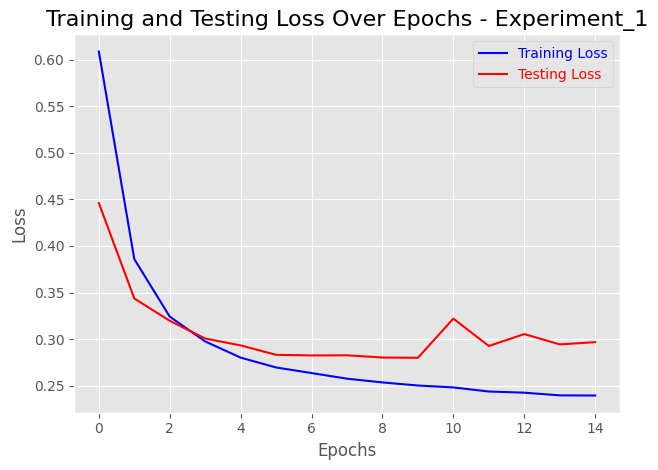

Train Losses: [0.6967111747741699, 0.6970648636817932, 0.6969578135490417, 0.6972886266708374, 0.6969903030395508, 0.6972275411605835, 0.6970221325874328, 0.6972145607948304, 0.6971422427177429, 0.6971032249450684, 0.6972361729621888, 0.6969682634353638, 0.6973351615905762, 0.6968954537391663, 0.6971214945793152]
Test Losses: [0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696, 0.6965520351555696]
Number of training loss entries: 15
Number of testing loss entries: 15


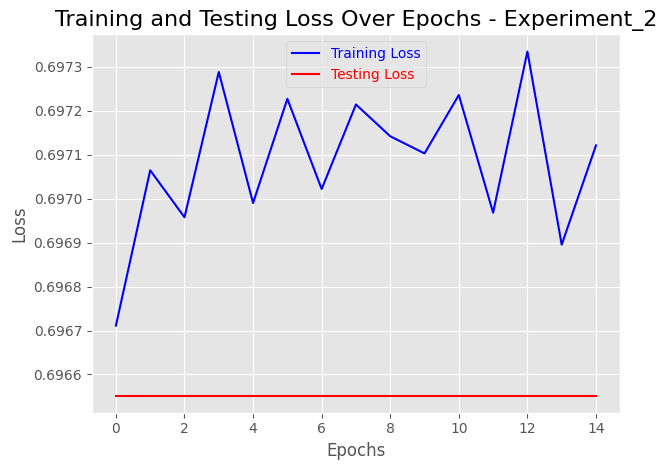

Train Losses: [0.6081085790157318, 0.37594183661937713, 0.3154309509277344, 0.2907559964895248, 0.27509520763158796, 0.2693889262676239, 0.25944136192798617, 0.25633024278879163, 0.25414276959896087, 0.248383229136467, 0.24454735321998597, 0.24291697793006897, 0.24021905212402345, 0.23880957498550415, 0.2372535638332367]
Test Losses: [0.44891296773199824, 0.33381713366812205, 0.3079680879214767, 0.2903620175969828, 0.2921616631993063, 0.30200970543038314, 0.2806255749551354, 0.2831449831367298, 0.2866699454511047, 0.2820177765883458, 0.28243208923347435, 0.28349775351156853, 0.2932441918903096, 0.2888084232902071, 0.2897601000442626]
Number of training loss entries: 15
Number of testing loss entries: 15


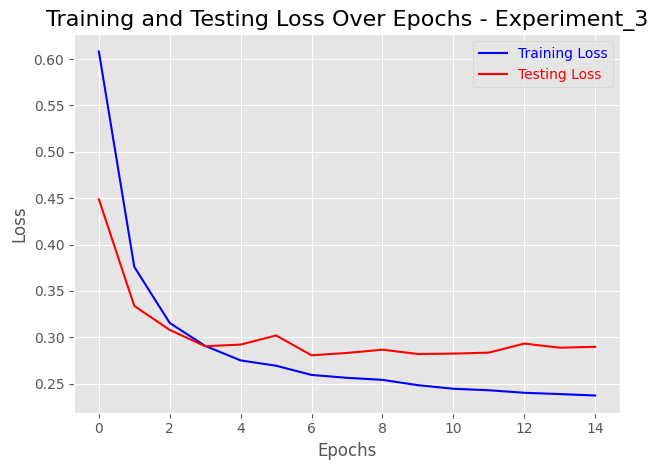

Train Losses: [0.6724581490516662, 0.4682439786672592, 0.35698391001224516, 0.32731793084144595, 0.3056994443416595, 0.29598943840265274, 0.28397082297801973, 0.2766101754426956, 0.27110447368621826, 0.2696981845140457, 0.26580031275749205, 0.2608401386499405, 0.2608810455441475, 0.257220530796051, 0.25626768581867215]
Test Losses: [0.5822927883476209, 0.3663687249467631, 0.3192072407265378, 0.30474894327722535, 0.289943104621711, 0.2898747383788892, 0.2844405983853492, 0.28119868362785144, 0.3017720442478824, 0.2843482890136682, 0.29390534089439235, 0.2791079095784266, 0.2872223594955578, 0.2798914822993005, 0.28546375349448744]
Number of training loss entries: 15
Number of testing loss entries: 15


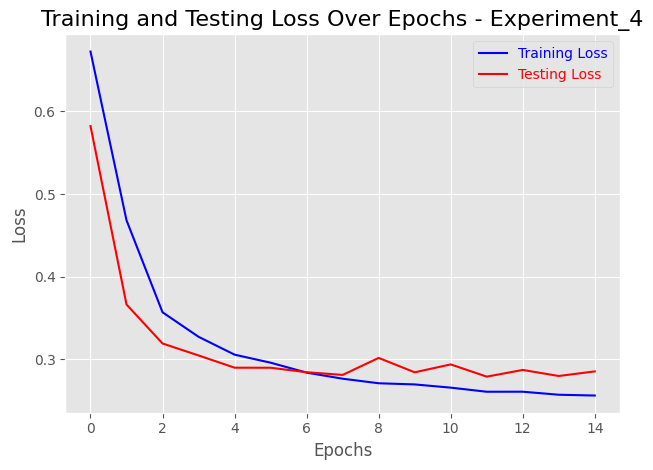

Train Losses: [0.6944026684761048, 0.6934362843513489, 0.6924325373649597, 0.6920626176834106, 0.6914644619941711, 0.6912002471923828, 0.6906202472686768, 0.6902292984008789, 0.6898636219978332, 0.6891012313842774, 0.6886590943336487, 0.6880695293426514, 0.6876758366584778, 0.6873589967727661, 0.6863173591613769]
Test Losses: [0.6927537143610085, 0.6922740624968413, 0.6918085752778752, 0.6913565932565434, 0.690912595979727, 0.690545783301068, 0.6900159306586928, 0.6895235006216984, 0.6891881052855473, 0.6886812099225962, 0.6879194906562757, 0.6877200037810454, 0.6866872071460554, 0.6863488061412885, 0.685313587735413]
Number of training loss entries: 15
Number of testing loss entries: 15


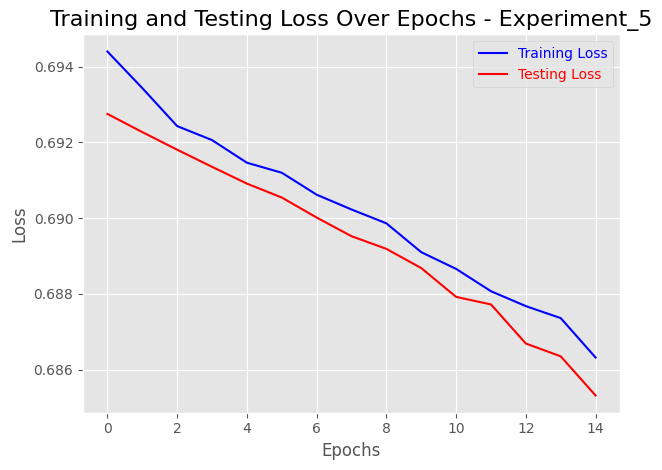

Train Losses: [0.49241557114124296, 0.3024654935479164, 0.28081546592712403, 0.26775589920282367, 0.2563131198525429, 0.24654694007635117, 0.2400771570444107, 0.22818735386133193, 0.22168145200014114, 0.21238796861171721, 0.20326434687376022, 0.19388844329714774, 0.18759397167563438, 0.17787811418175697, 0.17492690913677217]
Test Losses: [0.30703640041077973, 0.3201045495499471, 0.29909703012105004, 0.2849665254259565, 0.3051670803480847, 0.2945306524159802, 0.3598083597459611, 0.29884030617726076, 0.33363458219986813, 0.38744102513334555, 0.3688181245782573, 0.3855406641960144, 0.40622685963560823, 0.43513277894372393, 0.45306003710646536]
Number of training loss entries: 15
Number of testing loss entries: 15


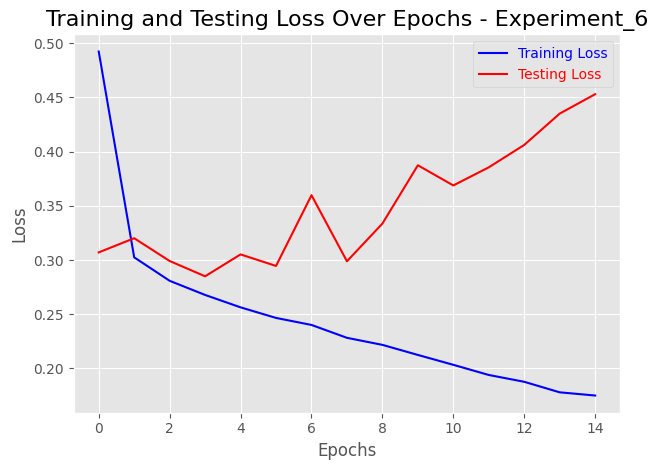

Train Losses: [0.5108270341396332, 0.29785037899017336, 0.2763362954735756, 0.26015118453502656, 0.249161122071743, 0.23278313947916032, 0.22081940301656722, 0.20673569960594176, 0.19436909683942794, 0.18278310585618018, 0.16928364511728286, 0.15619374114274978, 0.14371043314635754, 0.13964349089860917, 0.12606199769079685]
Test Losses: [0.2989983621296609, 0.27639215918862897, 0.2797582067406861, 0.2813788558457308, 0.42181915490870264, 0.31373357749099184, 0.3266207942632353, 0.3255240509084835, 0.3442979134192133, 0.39351975822904306, 0.4903298896873832, 0.4941623364664187, 0.5608673908148601, 0.590840007469153, 0.6061471313427967]
Number of training loss entries: 15
Number of testing loss entries: 15


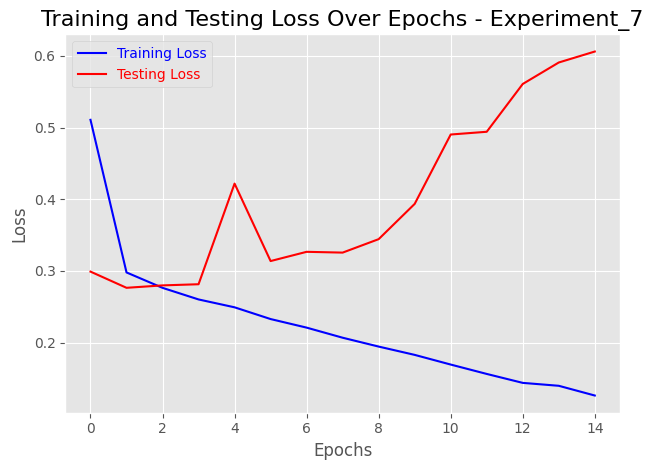

Train Losses: [0.47092434387207033, 0.29725385625362394, 0.2727551367521286, 0.25957465773820876, 0.24880119370222092, 0.2369728771328926, 0.22275368057489395, 0.21376845284700394, 0.2013801693737507, 0.18845878890752793, 0.17358907135128976, 0.15899178403615952, 0.14783779322504997, 0.1356763217329979, 0.1272260696530342]
Test Losses: [0.41663418833617194, 0.28596554240983, 0.30862742092958684, 0.33444556831174593, 0.2798764599831241, 0.3005745305567031, 0.30565812253648306, 0.3018393709686152, 0.34684131693118697, 0.33161451582126555, 0.38617449638190543, 0.46069955654964323, 0.5675803217443691, 0.4816175564459175, 0.5563540838326618]
Number of training loss entries: 15
Number of testing loss entries: 15


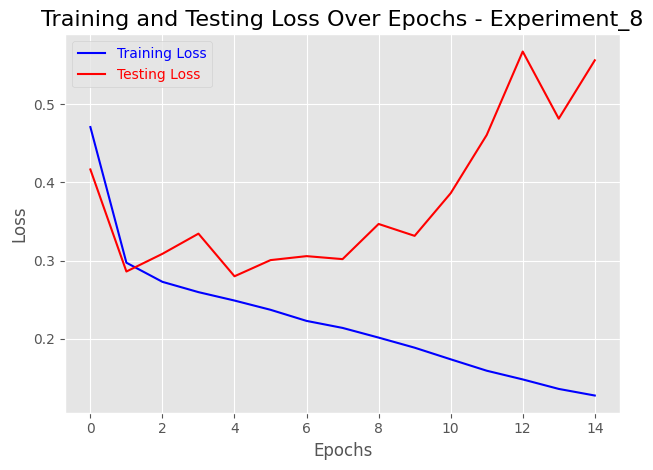

In [48]:
def train_and_test_res(train_losses,test_losses,experiment_name):
    print("Train Losses:", train_losses)
    print("Test Losses:", test_losses)
    print(f"Number of training loss entries: {len(train_losses)}")
    print(f"Number of testing loss entries: {len(test_losses)}")
    plt.style.use('ggplot')
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Testing Loss Over Epochs - {experiment_name}', fontsize=16)
    plt.legend(labelcolor='linecolor')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for experiment, result in experiment_results.items():
    train_and_test_res(result['train_losses'], result['test_losses'], experiment)


Results for Experiment_1:
Accuracy: 0.8730


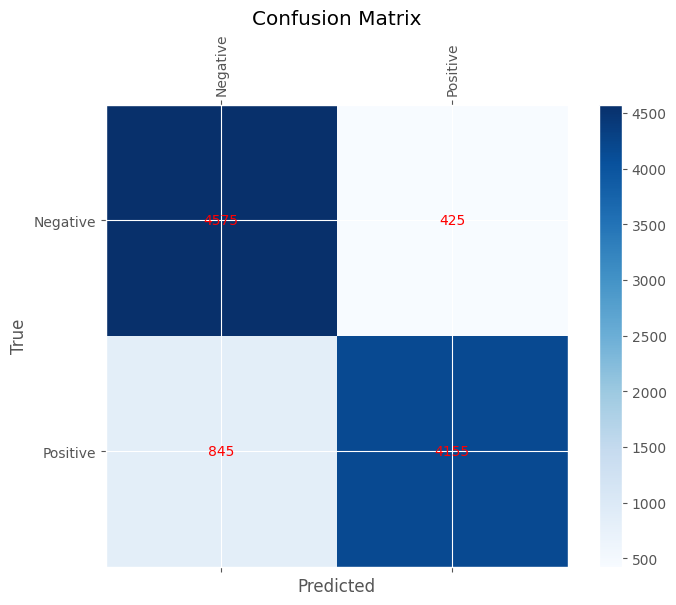

Results for Experiment_2:
Accuracy: 0.5000


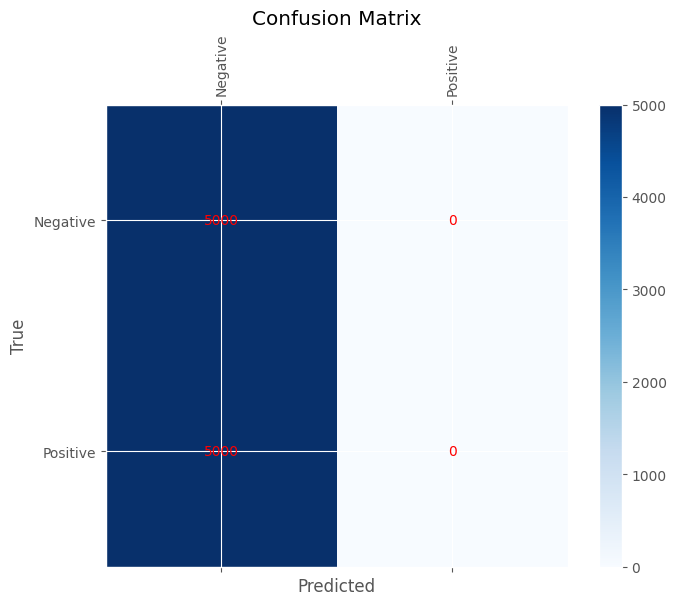

Results for Experiment_3:
Accuracy: 0.8807


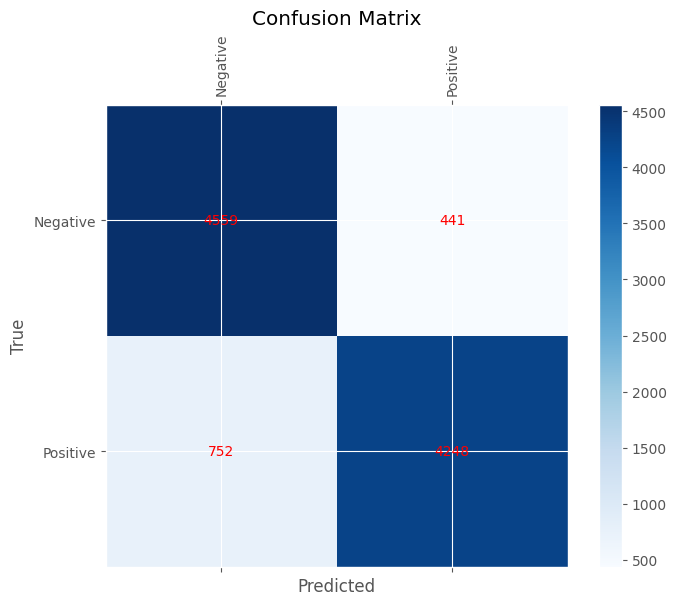

Results for Experiment_4:
Accuracy: 0.8841


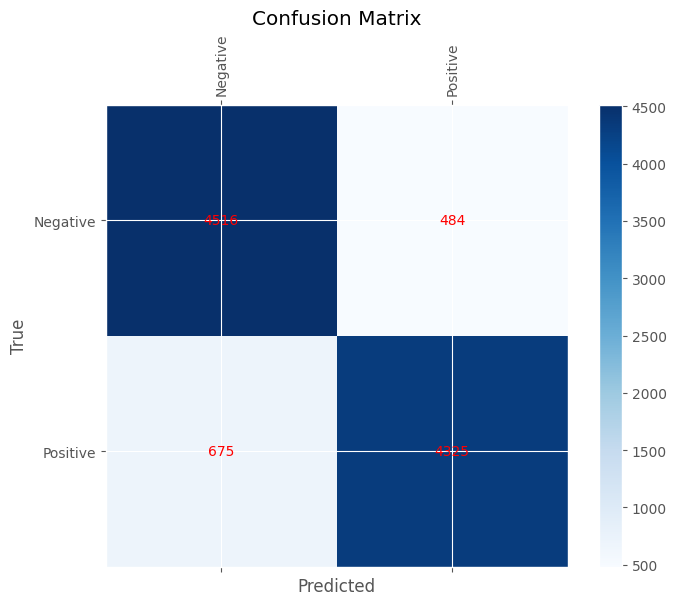

Results for Experiment_5:
Accuracy: 0.5808


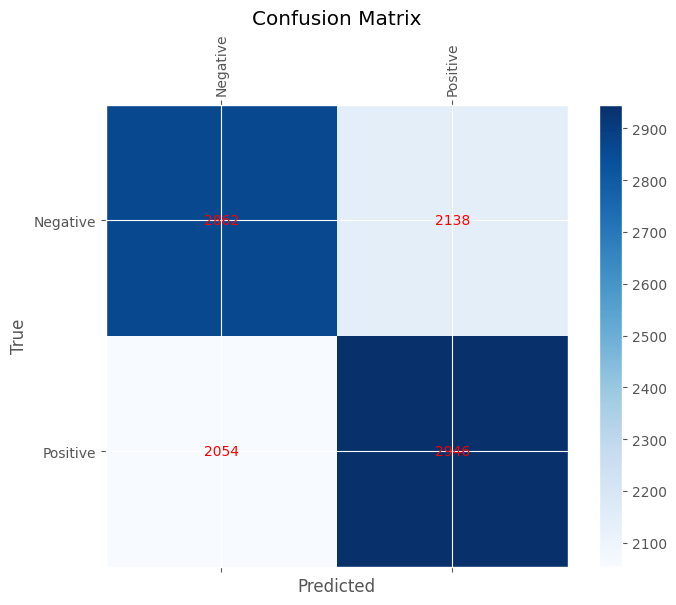

Results for Experiment_6:
Accuracy: 0.8694


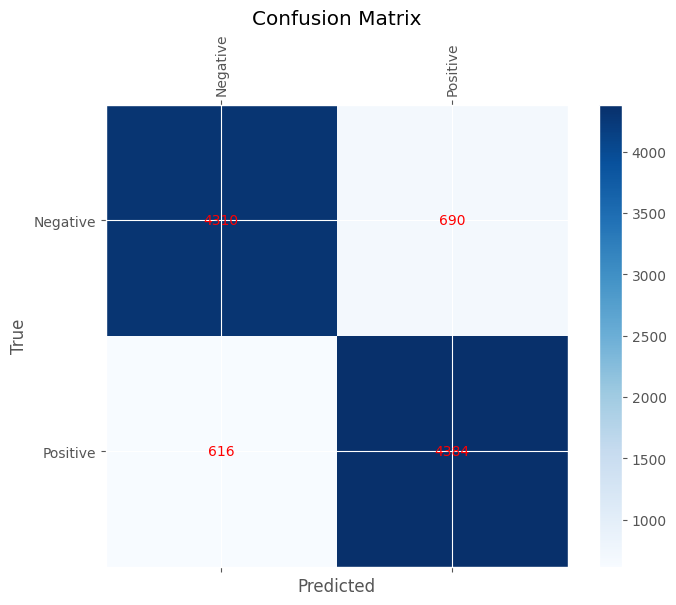

Results for Experiment_7:
Accuracy: 0.8601


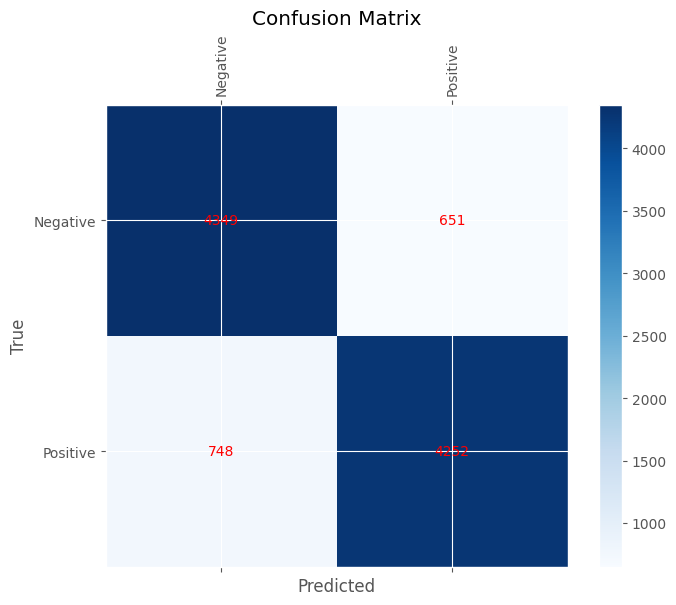

Results for Experiment_8:
Accuracy: 0.8689


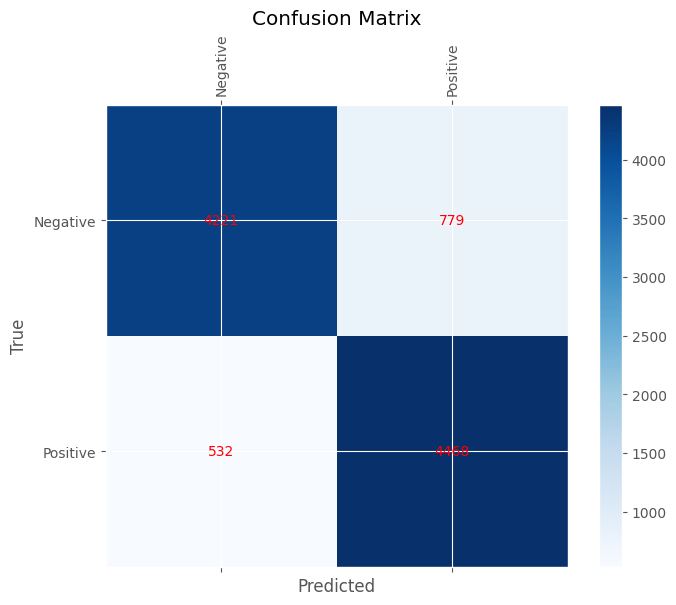

In [49]:

def plot_confusion_matrix(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device).long()
            labels = labels.to(device).float()
            predictions = model(texts).squeeze(1)
            predicted_labels = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    # Set tick positions
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # Set tick labels
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels for x-axis
    plt.xticks(rotation=90)

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


class_names = ['Negative', 'Positive']  # Adjust as per your labels

for experiment_name, experiment_result in experiment_results.items():
    print(f"Results for {experiment_name}:")
    trained_model = experiment_result['model']
    plot_confusion_matrix(trained_model, test_loader, device, class_names)

# we havnt able to reach above 88 % accuracy.

# Training a BiDir LSTM neural network

Now do the same as the prvious section with a bi-directional LSTM.

Remember that the output of the LSTM should be connected to a small feed forward network to perform the actual classification.

Here again you can play with number of layers and the LSTM or the small network of the output. Show only the best result you got.

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

Are the results better than the previous section?




In [63]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import random
from torch.utils.data import Dataset, DataLoader
import torch


class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

   def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        index = self.indices[idx]  # Fetch original index
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(len(sequence), dtype=torch.long), index

def pad_collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)  # Sort by length for efficient packing
    sequences, labels, lengths = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.stack(labels), torch.stack(lengths)


maxlen = 500  # Adjust based on your dataset analysis
sequences = data['indexed_text'].tolist()

data['numeric_sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Convert to list
labels = data['numeric_sentiment'].tolist()
print(f"Total sequences: {len(sequences)}")
print(f"Total labels: {len(labels)}")




train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42, stratify=labels)



dataset = TextDataset(sequences, labels)
# Create TextDataset instances for both training and testing data
train_dataset = TextDataset(train_sequences, train_labels)
test_dataset = TextDataset(test_sequences, test_labels)

# Create DataLoader instances for both training and testing datasets

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate_fn)




num_epochs = 15


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

def train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device):
    model.to(device)
    epoch_train_losses = []  # List to store average train loss per epoch
    epoch_test_losses = []  # List to store average test loss per epoch

    print("started training first epoch")
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for sequences, labels, lengths in train_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device),lengths
            #print(f"Batch Sequences Shape: {sequences.shape}")
            #print(f"Batch Labels Shape: {labels.shape}")
            #print(f"Batch Lengths Shape: {lengths.shape}")
            optimizer.zero_grad()
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        epoch_train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

        # Evaluation
        model.eval()
        test_losses = []
        with torch.no_grad():
            for sequences, labels, lengths in test_loader:
                sequences, labels, lengths = sequences.to(device), labels.to(device), lengths

                outputs = model(sequences, lengths)
                loss = criterion(outputs.squeeze(1), labels)

                test_losses.append(loss.item())

        avg_test_loss = sum(test_losses) / len(test_losses)
        epoch_test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

    # Return the model and the average losses for further analysis if needed
    return model, epoch_train_losses, epoch_test_losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_layers = 3
dropout = 0.6
hidden_dim = 128
model = BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
trained_model, train_loss, test_loss = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device)
## our highest epoch count was 20 - was yelding about 90% accuracy, which is an improvemnt.
## we can say that there is little overfit, and with maybe longer training of this kind of network
## with higher paramters, we can reach even higher.



Total sequences: 50000
Total labels: 50000
cuda
started training first epoch
Epoch [1/15], Loss: 0.6749
Test Loss: 0.6361
Epoch [2/15], Loss: 0.6438
Test Loss: 0.6736
Epoch [3/15], Loss: 0.6189
Test Loss: 0.6791
Epoch [4/15], Loss: 0.5894
Test Loss: 0.6560
Epoch [5/15], Loss: 0.5206
Test Loss: 0.8388
Epoch [6/15], Loss: 0.4737
Test Loss: 0.5118
Epoch [7/15], Loss: 0.4328
Test Loss: 0.5319
Epoch [8/15], Loss: 0.4114
Test Loss: 0.5424
Epoch [9/15], Loss: 0.3839
Test Loss: 0.5084
Epoch [10/15], Loss: 0.3657
Test Loss: 0.5045
Epoch [11/15], Loss: 0.3465
Test Loss: 0.4746
Epoch [12/15], Loss: 0.3304
Test Loss: 0.3627
Epoch [13/15], Loss: 0.3128
Test Loss: 0.3610
Epoch [14/15], Loss: 0.3041
Test Loss: 0.2935
Epoch [15/15], Loss: 0.2905
Test Loss: 0.2986


Results for BiDir LSTM:
Accuracy: 0.8902


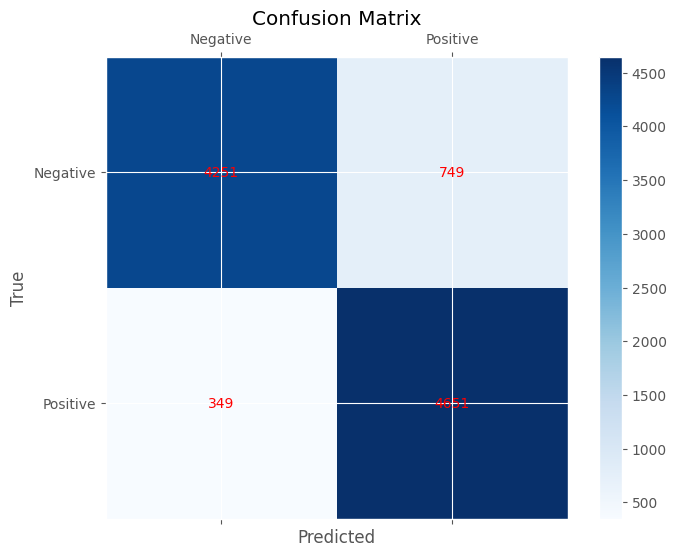

Text: [882, 1461, 1048, 1168, 193, 1696, 885, 338, 352, 1060, 220, 2521, 1, 2274, 882, 591, 1619, 2844, 1, 1390, 954, 293, 2727, 46, 2508, 786, 1770, 2274, 1286, 1390, 591, 1579, 145, 1780, 2505, 1095, 959, 1934, 2392, 2386, 2362, 2844, 1902, 2162, 786, 2188, 2440, 2505, 954, 1409, 818, 1060, 2645, 1202, 2392, 2274, 2739, 2559, 24, 2900, 852, 2139, 143, 2514, 1780, 788, 314, 2217, 788, 2645, 310, 591, 1060, 1, 1307, 1286, 2376, 1707, 143, 2895, 2386, 2362, 2790, 1, 1, 604, 1757, 1545, 1, 1, 2048, 2162, 1594, 2514, 1553, 707, 2274, 184, 510, 1619, 2645, 805, 788, 2503, 2844, 1, 2000, 1780, 1, 2274, 2705, 2923, 2639, 1734, 1, 1307, 2253, 1409, 954, 293, 2790, 1, 604, 306, 885, 235, 510, 2425, 2844, 1, 1307, 1625, 591, 461, 2508, 1780, 1961, 1200, 852, 882, 15, 428, 2633, 1707, 2274, 2739, 2162, 2645, 1150, 591, 1, 1523, 2593, 2162, 521, 2645, 1064, 2274, 2207, 2632, 1983, 2939, 2790, 2266, 2415, 604, 1061, 281, 2639, 1419, 1734, 490, 2715, 2386, 1, 1, 213, 1619, 879, 2162, 2645, 1150, 22

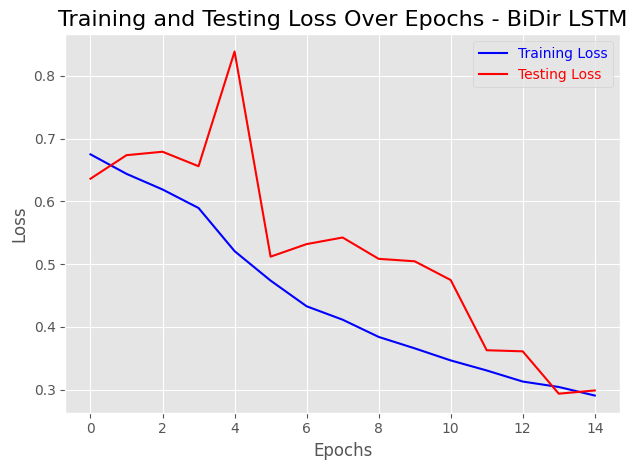

In [67]:

def plot_confusion_matrix_bidir(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels, lengths in data_loader:
            texts, lengths = texts.to(device), lengths
            labels = labels.to(device).float()
            predictions = model(texts, lengths).squeeze(1)
            predicted_labels = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)

    # Set ticks and labels explicitly
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print(f"Results for BiDir LSTM:")

plot_confusion_matrix_bidir(trained_model, test_loader, device, class_names)





train_and_test_res(train_loss,test_loss, 'BiDir LSTM')


Finally show 3 reviews from the test data with correct labales and 3 without, why do you think the network did not success on these examples?

In [66]:
import numpy as np

def evaluate_and_show_examples(model, test_loader, device, df):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []
    all_texts = []
    df_iter = iter(df['review'])  # Create an iterator over the original texts


    for i, (sequences, labels, lengths) in enumerate(test_loader):
         if i < 1:  # Just for the first batch
            print("Sequences:", sequences)
            print("Labels:", labels)
            # Fetch and print the corresponding texts and labels from the DataFrame
            batch_indices = range(i * test_loader.batch_size, (i + 1) * test_loader.batch_size)
            print("Original texts:", df.iloc[batch_indices]['review'].tolist())
            print("Original labels:", df.iloc[batch_indices]['numeric_sentiment'].tolist())

         else:
              break

    with torch.no_grad():
        for sequences, labels, lengths in test_loader:


            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths
            outputs = model(sequences, lengths)
            predicted_labels = torch.round(torch.sigmoid(outputs.squeeze(1)))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Fetch the original texts for each sequence in the batch
            batch_texts = [next(df_iter) for _ in range(len(labels))]
            all_texts.extend(batch_texts)

    correct_examples = []
    incorrect_examples = []

    # Analyze predictions
    for text, pred, label in zip(all_texts, all_predictions, all_labels):
        if pred == label:
            correct_examples.append((text, pred, label))
        else:
            incorrect_examples.append((text, pred, label))

    # Randomly select 3 correct and 3 incorrect examples
    selected_correct = random.sample(correct_examples, min(3, len(correct_examples)))
    selected_incorrect = random.sample(incorrect_examples, min(3, len(incorrect_examples)))

    print("Correctly Classified Examples:")
    for text, pred, label in selected_correct:
        print(f"Text: {text}\nPredicted: {pred}, Actual: {label}\n")

    print("\nIncorrectly Classified Examples:")
    for text, pred, label in selected_incorrect:
        print(f"Text: {text}\nPredicted: {pred}, Actual: {label}\n")


# Assuming 'data' is your dataset containing the original texts and 'index_to_word' is a dictionary mapping indices back to words
evaluate_and_show_examples(trained_model, test_loader, device, data)


Sequences: tensor([[1326, 1983, 2567,  ..., 1942, 2038, 2274],
        [   1, 1517, 2844,  ...,    0,    0,    0],
        [   1,    1,  788,  ...,    0,    0,    0],
        ...,
        [1286, 2217,  136,  ...,    0,    0,    0],
        [2565, 1419, 2844,  ...,    0,    0,    0],
        [ 931, 2274,  882,  ...,    0,    0,    0]])
Labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
Original texts: ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted 

 # answers
 ---
- **Feedforward Neural Network**: The previous code utilizes a simple feedforward neural network architecture. It consists of an embedding layer followed by one or more fully connected hidden layers with ReLU activation functions. The final layer produces the output for sentiment classification.
   - **Bidirectional LSTM**: In contrast, the latest code employs a Bidirectional Long Short-Term Memory (LSTM) neural network. This architecture includes an embedding layer, followed by a Bidirectional LSTM layer. The output of the LSTM layer is then fed into a small feedforward network for the actual classification. LSTMs are specialized recurrent neural networks capable of capturing long-term dependencies in sequential data like text.

2. **Handling Sequential Data**:
   - **Feedforward Neural Network**: Feedforward networks process input data sequentially, treating each word or token independently. They lack the ability to capture contextual information from neighboring words effectively.
   - **Bidirectional LSTM**: LSTMs, on the other hand, are designed to handle sequential data more effectively. Bidirectional LSTMs, in particular, process input sequences in both forward and backward directions, allowing them to capture contextual information from both past and future words. This bidirectional processing is beneficial for tasks like sentiment analysis where context plays a crucial role.

3. **Padding and Packing**:
   - **Feedforward Neural Network**: In the feedforward network, padding to ensure uniform sequence lengths is not explicitly required since the model treats each input independently.
   - **Bidirectional LSTM**: In the LSTM model, padding and packing of sequences are essential. Sequences are padded to a fixed length to ensure uniformity, and then packed to remove unnecessary padding before feeding them into the LSTM layer. This packing helps in efficient processing of variable-length sequences.

4. **Training Procedure**:
   - **Feedforward Neural Network**: Training a feedforward neural network involves standard forward and backward passes, followed by parameter updates.
   - **Bidirectional LSTM**: Training a Bidirectional LSTM requires additional steps due to the sequential nature of the data. The sequences are sorted by length for efficient packing, and the model is trained using packed sequences. Additionally, the model is evaluated similarly using packed sequences during testing.

5. **Evaluation and Analysis**:
   - **Feedforward Neural Network**: Evaluation of the feedforward network typically involves computing metrics such as accuracy and possibly a confusion matrix to assess its performance.
   - **Bidirectional LSTM**: Evaluation of the Bidirectional LSTM includes similar metrics but may also involve analyzing correctly and incorrectly classified examples to gain insights into the model's behavior, especially regarding contextual understanding.

In summary, while both approaches aim to perform sentiment analysis on textual data, they differ significantly in their underlying architectures and mechanisms for handling sequential data. The Bidirectional LSTM model offers advantages in capturing contextual information, which is crucial for tasks like sentiment analysis, where the meaning of a word can depend heavily on its context within a sentence.
